In [ ]:
%%file trial_kpp.cpp

#include <iostream>
#include <Eigen/Dense>
#include <cmath>

Eigen::MatrixXd distance(Eigen::MatrixXd xs, Eigen::MatrixXd centroid, bool default_weight=true,
                         Eigen::VectorXd weights=Eigen::VectorXd::Ones(1))
{    
    /*
    Computes matrix of squared distance from each point to each centroid.
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    centroid: ndarray of k centroids in d dimensional Euclidean space (kxd)
    default_weight: a boolean value 0 and 1
    weights: ndarray of n dimensions(n)
    
    Returns:
    --------
    distance: matrix of squared distances (nxk)
    */
    int n = xs.rows();
    int k = centroid.rows();
    int d = xs.cols();
    Eigen::MatrixXd distance_matrix(n,k);
    
    if (default_weight==true)
    {
        weights = Eigen::VectorXd::Ones(n);
    }
    
    for (int col_index=0; col_index<k; col_index++)
    {
        for (int row_index=0; row_index<n; row_index++)
        {
            double dist = (xs.row(row_index) - centroid.row(col_index)).norm();
            distance_matrix(row_index,col_index) = weights(row_index) * std::pow(dist,2);
        }
    }
    return distance_matrix;
}

double cost(Eigen::MatrixXd distance_matrix)
{
    /*
    Computes the cost of a set of points with respect to a collection of centroids
    
    Parameters:
    -----------
    distance_matrix : matrix of squared distances (nxk); likely returned from distance() function
    
    Returns:
    --------
    cost: cost with respect to centroids
    */
    double cost;
    cost = distance_matrix.rowwise().minCoeff().sum();
    return cost;
}

Eigen::VectorXd centroid_weights(Eigen::MatrixXd distance_matrix)
{
    /*
    Computes weights as defined in step 7 of the k-means|| algorithm
        
    Parameters:
    -----------
    distance_matrix : matrix of squared distances (nxk); likely returned from distance() function
    centroid: ndarray of k centroids in d dimensional Euclidean space (kxd)
    
    Returns:
    --------
    w_x: ndarray of weights applied to centroids (kx1)
    */
    int n = distance_matrix.rows();
    int k = distance_matrix.cols();
    Eigen::MatrixXd weight_matrix(n,k);
    weight_matrix.fill(0);
    Eigen::VectorXd w_x(k);
    for (int row_index=0; row_index<n; row_index++)
    {
        double row_minimum_value = distance_matrix.row(row_index).minCoeff();
        for (int col_index=0; col_index<k; col_index++)
        {
            if (distance_matrix(row_index,col_index)==row_minimum_value)
            {
                weight_matrix(row_index,col_index)=1;
            }
        }
    }
    w_x = weight_matrix.colwise().sum();
    return w_x;
}

Eigen::MatrixXd k_means_pp(Eigen::MatrixXd xs, int k, int sd, bool verbose, Eigen::VectorXd weights)
{
    /*
    Implements the K_means++ Initialization algorithm
    
    Parameters:
    -----------
    xs: input dataset
    k: the number of output clusters
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    */
    std::default_random_engine seed{sd}; // setting a seed
    
    int n = xs.rows();
    int d = xs.cols();
    int starting_index = rand() % n;
    Eigen::MatrixXd C = xs.row(starting_index);
    int loop = 0;
    
    while (C.rows() < k)
    {
        if ((loop % 10 == 0) & (verbose == true))
        {
            std::cout << "The current loop is: " << loop << std::endl;
        }
        Eigen::MatrixXd dist = distance(xs, C, true, Eigen::VectorXd::Ones(1));
        double cst = cost(dist);
        Eigen::VectorXd probs_x = dist.rowwise().minCoeff() / cst;
        std::default_random_engine generator;
        std::uniform_real_distribution<double> distribution(0.0,1.0);
        double random_number = distribution(generator);
        double sum_prob = 0;
        int index;
        for (int i=0; i<probs_x.size(); i++)
        {
            sum_prob += probs_x(i);
            if (sum_prob >= random_number)
            {
                index = i;
                break;
            }
        }
        Eigen::MatrixXd C_new = xs.row(index);
        Eigen::MatrixXd temp(C.rows()+C_new.rows(), C.cols());
        temp << C, C_new;        
        C = temp;
    }
    
    return C;
}

Eigen::MatrixXd k_means_parallel(Eigen::MatrixXd xs, int k, double l, int sd, int max_iter)
{
    std::default_random_engine seed{sd}; // setting a seed
    
    int n = xs.rows();
    int d = xs.cols();
    int starting_index = rand() % n;
    int n_iter;
    Eigen::MatrixXd centroid = xs.row(starting_index);
    Eigen::MatrixXd dist = distance(xs, centroid);
    double cost_init = cost(dist);
    int order = std::ceil(std::log10(cost_init));
    
    if (max_iter == 0)
    {
        n_iter = order;
    } else {
        n_iter = max_iter;
    }
    
    for (int i=0; i<n_iter; i++)
    {
        Eigen::MatrixXd distance_matrix = distance(xs, centroid);
        double cst = cost(distance_matrix);
        Eigen::VectorXd probs_x = l * distance_matrix.rowwise().minCoeff() / cst;
        
        for (int a=0; a<n; a++)
        {
            if (probs_x(a) > 1)
            {
                probs_x(a) = 1;
            }
            std::default_random_engine generator;
            std::bernoulli_distribution distribution(probs_x(a));
            if (distribution(generator))
            {
                Eigen::MatrixXd C_new = xs.row(a);
                Eigen::MatrixXd temp(centroid.rows()+C_new.rows(), centroid.cols());
                temp << centroid, C_new;        
                centroid = temp;
            }
        }
    }
    
    Eigen::MatrixXd new_dist = distance(xs, centroid);
    Eigen::VectorXd w_x = centroid_weights(new_dist);
    
    Eigen::MatrixXd C;
    return k_means_pp(centroid, k, sd, true, w_x);
}

Eigen::MatrixXd k_means(Eigen::MatrixXd X, int k, Eigen::MatrixXd &centroids)
{
    int max_iter = 10000;
    int step = 0;
    int n = X.rows();
    
    while (step < max_iter)
    {
        Eigen::MatrixXd distance_matrix = distance(X, centroids);
        Eigen::MatrixXd weight_matrix(n,k);
        weight_matrix.fill(0);
        for (int row_index=0; row_index<n; row_index++)
        {
            double row_minimum_value = distance_matrix.row(row_index).minCoeff();
            for (int col_index=0; col_index<k; col_index++)
            {
                if (distance_matrix(row_index,col_index)==row_minimum_value)
                {
                    weight_matrix(row_index,col_index)=1;
                }
            }
        }
        
        Eigen::MatrixXd update_centroids(centroids.rows(), centroids.cols());
        for (int c=0; c<k; c++)
        {
            int count = weight_matrix.col(c).sum();
            update_centroids.row(c) = (X.transpose()*weight_matrix.col(c)).array() / count;
        }
        
        if (centroids == update_centroids)
        {
            return centroids;
        } else {
            centroids = update_centroids;
            step += 1;
        }
        
    }
    return centroids;
}



int main()
{
    Eigen::MatrixXd A1(3,3);
    A1 << 5 ,7, 9,
          4, 5, 6,
          7, 8, 9.0;
    Eigen::MatrixXd A2(4,4);
    A2 << 5 ,7, 9, 2,
          4, 5, 6, 3,
          7, 8, 9.0, 1,
          5, 1, 12, 5;
    Eigen::VectorXd x1(3);
    x1 << 10,13,25;    
    Eigen::VectorXd x2(3);
    x2 << 10,13,24;    
    Eigen::MatrixXd A3(3,3);
    A3 << 5 ,7, 9,
          4, 5, 6,
          7, 8, 9.0;
    
    //Eigen::MatrixXd xs, int k, int sd, bool verbose, Eigen::VectorXd weights
    //Eigen::MatrixXd xs, int k, double l, int sd, int max_iter
    std::cout << k_means_parallel(A2, 2, 2, 12312, 5) << std::endl;
}

In [ ]:
%%bash
g++ trial_kpp.cpp -o trial_kpp.exe -std=c++14 -I/usr/include/eigen3

In [ ]:
%%bash
./trial_kpp.exe

In [1]:
%%file k_means_wrap.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../notebooks/eigen3']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include <pybind11/eigen.h>
#include <pybind11/stl.h>
#include <pybind11/cast.h>

Eigen::MatrixXd distance(Eigen::MatrixXd xs, Eigen::MatrixXd centroid, bool default_weight=true,
                         Eigen::VectorXd weights=Eigen::VectorXd::Ones(1))
{    
    /*
    Computes matrix of squared distance from each point to each centroid.
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    centroid: ndarray of k centroids in d dimensional Euclidean space (kxd)
    default_weight: a boolean value 0 and 1
    weights: ndarray of n dimensions(n)
    
    Returns:
    --------
    distance: matrix of squared distances (nxk)
    */
    int n = xs.rows();
    int k = centroid.rows();
    int d = xs.cols();
    Eigen::MatrixXd distance_matrix(n,k);
    
    if (default_weight==true)
    {
        weights = Eigen::VectorXd::Ones(n);
    }
    
    for (int col_index=0; col_index<k; col_index++)
    {
        for (int row_index=0; row_index<n; row_index++)
        {
            double dist = (xs.row(row_index) - centroid.row(col_index)).norm();
            distance_matrix(row_index,col_index) = weights(row_index) * std::pow(dist,2);
        }
    }
    return distance_matrix;
}

double cost(Eigen::MatrixXd distance_matrix)
{
    /*
    Computes the cost of a set of points with respect to a collection of centroids
    
    Parameters:
    -----------
    distance_matrix : matrix of squared distances (nxk); likely returned from distance() function
    
    Returns:
    --------
    cost: cost with respect to centroids
    */
    double cost;
    cost = distance_matrix.rowwise().minCoeff().sum();
    return cost;
}

Eigen::VectorXd centroid_weights(Eigen::MatrixXd distance_matrix)
{
    /*
    Computes weights as defined in step 7 of the k-means|| algorithm
        
    Parameters:
    -----------
    distance_matrix : matrix of squared distances (nxk); likely returned from distance() function
    centroid: ndarray of k centroids in d dimensional Euclidean space (kxd)
    
    Returns:
    --------
    w_x: ndarray of weights applied to centroids (kx1)
    */
    int n = distance_matrix.rows();
    int k = distance_matrix.cols();
    Eigen::MatrixXd weight_matrix(n,k);
    weight_matrix.fill(0);
    Eigen::VectorXd w_x(k);
    for (int row_index=0; row_index<n; row_index++)
    {
        double row_minimum_value = distance_matrix.row(row_index).minCoeff();
        for (int col_index=0; col_index<k; col_index++)
        {
            if (distance_matrix(row_index,col_index)==row_minimum_value)
            {
                weight_matrix(row_index,col_index)=1;
            }
        }
    }
    w_x = weight_matrix.colwise().sum();
    return w_x;
}

Eigen::MatrixXd k_means_pp(Eigen::MatrixXd xs, int k, int sd, bool verbose, Eigen::VectorXd weights)
{
    /*
    Implements the K_means++ Initialization algorithm
    
    Parameters:
    -----------
    xs: input dataset
    k: the number of output clusters
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    */
    std::default_random_engine seed{sd}; // setting a seed
    
    int n = xs.rows();
    int d = xs.cols();
    int starting_index = rand() % n;
    Eigen::MatrixXd C = xs.row(starting_index);
    int loop = 0;
    
    while (C.rows() < k)
    {
        if ((loop % 10 == 0) & (verbose == true))
        {
            std::cout << "The current loop is: " << loop << std::endl;
        }
        Eigen::MatrixXd dist = distance(xs, C, true, Eigen::VectorXd::Ones(1));
        double cst = cost(dist);
        Eigen::VectorXd probs_x = dist.rowwise().minCoeff() / cst;
        std::default_random_engine generator;
        std::uniform_real_distribution<double> distribution(0.0,1.0);
        double random_number = distribution(generator);
        double sum_prob = 0;
        int index;
        for (int i=0; i<probs_x.size(); i++)
        {
            sum_prob += probs_x(i);
            if (sum_prob >= random_number)
            {
                index = i;
                break;
            }
        }
        Eigen::MatrixXd C_new = xs.row(index);
        Eigen::MatrixXd temp(C.rows()+C_new.rows(), C.cols());
        temp << C, C_new;        
        C = temp;
    }
    
    return C;
}

Eigen::MatrixXd k_means_parallel(Eigen::MatrixXd xs, int k, double l, int sd, int max_iter)
{
    std::default_random_engine seed{sd}; // setting a seed
    
    int n = xs.rows();
    int d = xs.cols();
    int starting_index = rand() % n;
    int n_iter;
    Eigen::MatrixXd centroid = xs.row(starting_index);
    Eigen::MatrixXd dist = distance(xs, centroid);
    double cost_init = cost(dist);
    int order = std::ceil(std::log10(cost_init));
    
    if (max_iter == 0)
    {
        n_iter = order;
    } else {
        n_iter = max_iter;
    }
    
    for (int i=0; i<n_iter; i++)
    {
        Eigen::MatrixXd distance_matrix = distance(xs, centroid);
        double cst = cost(distance_matrix);
        Eigen::VectorXd probs_x = l * distance_matrix.rowwise().minCoeff() / cst;
        
        for (int a=0; a<n; a++)
        {
            if (probs_x(a) > 1)
            {
                probs_x(a) = 1;
            }
            std::default_random_engine generator;
            std::bernoulli_distribution distribution(probs_x(a));
            if (distribution(generator))
            {
                Eigen::MatrixXd C_new = xs.row(a);
                Eigen::MatrixXd temp(centroid.rows()+C_new.rows(), centroid.cols());
                temp << centroid, C_new;        
                centroid = temp;
            }
        }
    }
    
    Eigen::MatrixXd new_dist = distance(xs, centroid);
    Eigen::VectorXd w_x = centroid_weights(new_dist);
    
    return k_means_pp(centroid, k, sd, true, w_x);
}

Eigen::MatrixXd k_means(Eigen::MatrixXd X, int k, Eigen::MatrixXd &centroids)
{
    int max_iter = 10000;
    int step = 0;
    int n = X.rows();
    
    while (step < max_iter)
    {
        Eigen::MatrixXd distance_matrix = distance(X, centroids);
        Eigen::MatrixXd weight_matrix(n,k);
        weight_matrix.fill(0);
        for (int row_index=0; row_index<n; row_index++)
        {
            double row_minimum_value = distance_matrix.row(row_index).minCoeff();
            for (int col_index=0; col_index<k; col_index++)
            {
                if (distance_matrix(row_index,col_index)==row_minimum_value)
                {
                    weight_matrix(row_index,col_index)=1;
                }
            }
        }
        
        Eigen::MatrixXd update_centroids(centroids.rows(), centroids.cols());
        for (int c=0; c<k; c++)
        {
            int count = weight_matrix.col(c).sum();
            update_centroids.row(c) = (X.transpose()*weight_matrix.col(c)).array() / count;
        }
        
        if (centroids == update_centroids)
        {
            return centroids;
        } else {
            centroids = update_centroids;
            step += 1;
        }
        
    }
    return centroids;
}

PYBIND11_MODULE(k_means_wrap, m) {
    m.doc() = "helpers functions for k-means|| initialization";
    m.def("distance", &distance, "distance matrix function");
    m.def("cost", &cost, "cost function");
    m.def("centroid_weights", &centroid_weights, "distance matrix function");
    m.def("k_means_pp", &k_means_pp, "k-means++ algorithm");
    m.def("k_means_parallel", &k_means_parallel, "k-means|| algorithm");
    m.def("k_means", &k_means, "k-means algorithm");
}

Overwriting k_means_wrap.cpp


In [2]:
import cppimport
cppimport.force_rebuild()
k_means_wrap = cppimport.imp("k_means_wrap")

### Testing

In [3]:
from multiprocessing import Pool
from functools import partial
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [9]:
def distance(xs, centroid, weights = np.array([1])):
    """Computes matrix of squared distance from each point to each centroid.
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    centroid: ndarray of k centroids in d dimensional Euclidean space (kxd)
    weights: an optional input of weights applied to each data point
    
    Returns:
    --------
    distance: matrix of squared distances (nxk)
    """
    if weights.all() == 1:
        weights = np.ones(xs.shape[0])

    distance = weights[:,None]*np.sum((xs[:,None,:] - centroid)**2, axis=-1)
    return distance

def cost(d):
    """Computes the cost of a set of points with respect to a collection of centroids
    
    Parameters:
    -----------
    d : matrix of squared distances (nxk) returned from distance() function
    
    Returns:
    --------
    cost: cost with respect to centroids
    """
    #calculate distance to the nearest centroid for each point
    min_dist = np.min(d, axis = 1)
    
    #compute cost
    cost = np.sum(min_dist)
    return cost

def centroid_weights(d):
    """Computes weights as defined in step 7 of the k-means|| algorithm
        
    Parameters:
    -----------
    d : matrix of squared distances (nxk) returned from distance() function
    
    Returns:
    --------
    w_x: ndarray of weights applied to centroids (kx1)
    """
    #identify closest centroid to each point
    c_close = np.zeros(d.shape)
    c_close[np.arange(d.shape[0]), np.argmin(d, axis = 1)] = 1
    
    #compute the weights
    w_x = np.sum(c_close, axis = 0)
    return w_x

In [10]:
def k_means_pp(xs, k, seed=None, verbose=False, weights = np.array([1])):
    """
    Implements the K_means++ Initialization algorithm
    
    Parameters:
    -----------
    xs: input dataset
    k: the number of output clusters
    seed: an optional random seed
    verbose: an optional argument to show progress of algorithm
    weights: an optional input of weights applied to each data point 
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    #initialization
    np.random.seed(seed)
    C = xs[np.random.choice(xs.shape[0],1),:]
    loop = 0
    
    while len(C)<k:
        
        if ((loop % 10 == 0)&(verbose == True)):
            print("The current loop is:", loop)
        
        dist = distance(xs,C, weights = weights)
        cst = cost(dist)
        
        probs_x = np.min(dist, axis = 1)/cst
        C_new = xs[np.random.choice(xs.shape[0],1,p=probs_x),:]
        
        C = np.vstack((C,C_new))
        
        loop += 1
        
    return C

In [11]:
def K_Means_ll(xs, k, l, seed=None, max_iter=None):
    """Implements the K_means || algorithm
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    k: the number of output clusters
    l: the oversampling factor; the number of centroids to sample at each iteration
    seed: an optional random seed
    max_iter: an optional argument to seet the number of iterations
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    
    #initialization
    np.random.seed(seed)
    centroid = xs[np.random.choice(xs.shape[0],1),:]
    cost_int = cost(distance(xs,centroid))
    
    order = np.log10(cost_int)
    
    if max_iter is not None:
        n_iter = max_iter
    else:
        n_iter = np.round(order)
    
    for i in np.arange(n_iter):
        dist = distance(xs,centroid)
        cst = cost(dist)
        
        probs_x = l*np.min(dist, axis = 1)/cst
        
        if any(probs_x > 1):
            probs_x[np.where(probs_x > 1)] = 1
        
        centroid_new = xs[np.random.binomial(1, p = probs_x) == 1,:]
        
        centroid = np.vstack((centroid,centroid_new))
    
    if centroid.shape[0] < k:
        return print('Error: Number of centers selected before reclustering is less than k;',
                    'adjust hyperparameters (k,l) or run for more iterations')
    
    dist = distance(xs,centroid)
    w_x = centroid_weights(dist)
    
    #Implement k-means++ to recluster weighted points in C
    C = k_means_pp(centroid,k,seed=seed,weights=w_x)

    return C

In [4]:
def GaussMix(R, k, n=10000, d=15, seed=None):
    """Generates GaussMixture synthetic dataset"""
    np.random.seed(seed)
    mu = np.zeros(d)
    sigma = np.diag(R*np.ones(d))
    centers = np.random.multivariate_normal(mean=mu, cov=sigma, size=k)
    
    X,y = make_blobs(n_samples=n, n_features=d, centers=centers, random_state=seed)
    return X,y

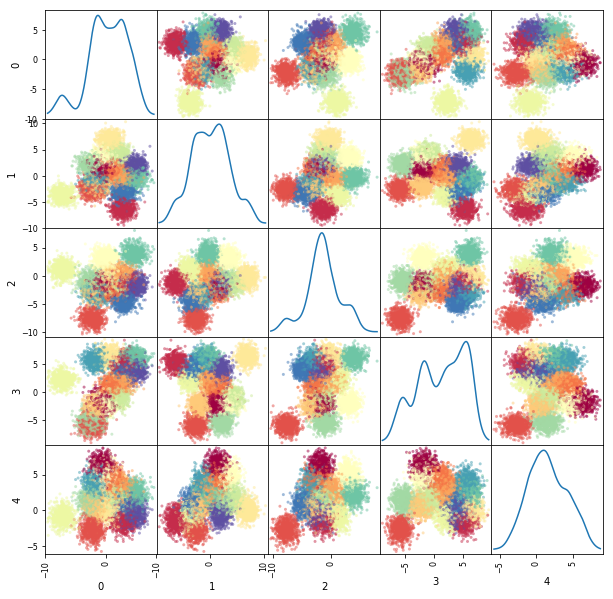

In [5]:
k=15
GM = GaussMix(10,k,seed=12345)
df = pd.DataFrame(GM[0])
y = GM[1]
pd.plotting.scatter_matrix(df.iloc[:,0:5], c=y, figsize=(10,10),
                           diagonal='kde', alpha=0.5, cmap='Spectral')
pass

In [6]:
xs = GM[0] #data is from GaussMix dataset
cent = xs[np.random.choice(xs.shape[0],5),:]

In [7]:
%%time

initial_centroids = k_means_wrap.k_means_pp(xs, 15, 12345, True, np.array([1]))

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 32.6 ms


In [8]:
%%time

initial_centroids = k_means_wrap.k_means_parallel(xs, 15, 10, 12345, 5)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 4.46 ms


In [12]:
%%time

initial_centroids = K_Means_ll(xs, 15, 10, seed=12345, max_iter=5)

CPU times: user 156 ms, sys: 52 ms, total: 208 ms
Wall time: 207 ms
